In [117]:
import gzip
from pathlib import Path
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import torchvision
from torchinfo import summary

import torch
from torch import nn

plt.rcParams["image.cmap"] = "gray"
import pickle
from typing import Dict, List, Tuple

import numpy as np
import PIL
from tqdm.auto import tqdm

%matplotlib inline

In [118]:
BATCH_SIZE = 32

In [119]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## MNIST Dataset

**Official Source**: http://yann.lecun.com/exdb/mnist/

The MNIST database of handwritten digits, available from this page, has a training set of **60,000** examples, and a test set of **10,000** examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

Since, I wasn't able to download the dataset from the official source, the alternate link I used is:
- https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true

In [121]:
MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"

In [122]:
root_dir = Path("data/mnist")
Path.mkdir(root_dir, exist_ok=True)
print("Making directory:", root_dir.name)
download_file_dir = root_dir / "mnist.pkl.gz"
if not download_file_dir.exists():
    print("Downloading file 'mnist.pkl.gz' at path: ", download_file_dir.name)
    urlretrieve(MNIST_URL, download_file_dir)
else:
    print("Already downloaded at path:", download_file_dir.name)

Making directory: mnist
Already downloaded at path: mnist.pkl.gz


In [123]:
with gzip.open(download_file_dir, "rb") as mnist:
    # Destructing the data
    ((X_train, y_train), (X_test, y_test), _) = pickle.load(mnist, encoding="latin-1")

In [124]:
# Training set consists of 50000 images with shape (28, 28)
# Images are stored in flattened format
X_train.shape, y_train.shape

((50000, 784), (50000,))

In [125]:
X_train = X_train.reshape(-1, 28, 28)
X_train = [np.array([j * 255 for j in x], dtype=np.uint8) for x in X_train]

X_test = X_test.reshape(-1, 28, 28)
X_test = [np.array([j * 255 for j in x], dtype=np.uint8) for x in X_test]

### Visualising the images

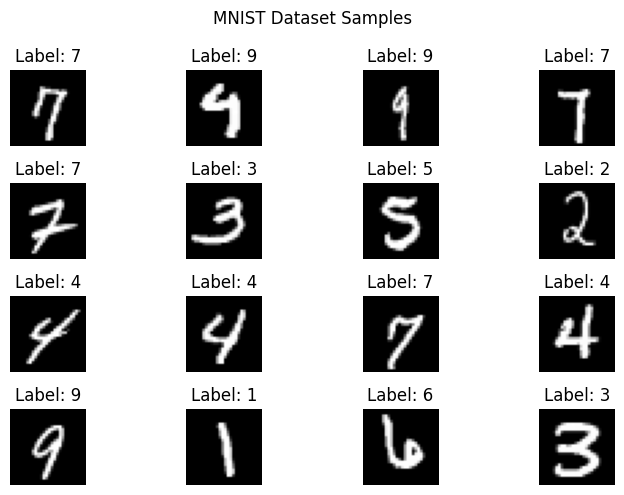

In [129]:
nrows, ncols = 4, 4
figure = plt.figure(figsize=(9, 5))
plt.suptitle("MNIST Dataset Samples")
for i in range(1, nrows * ncols + 1):
    random_idx = torch.randint(0, len(X_train) - 1, (1,))
    rand_img, rand_img_label = (
        X_train[random_idx].reshape(28, 28, 1),
        y_train[random_idx],
    )
    figure.add_subplot(nrows, ncols, i)
    plt.imshow(rand_img)
    plt.title(f"Label: {rand_img_label}")
    plt.axis(False)
    plt.tight_layout()
plt.show()

In [130]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        images,
        image_labels,
        transform=None,
        target_transform=None,
    ) -> None:
        self.images = images
        self.image_labels = image_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.image_labels[idx]
        if self.transform:
            image = self.transform(PIL.Image.fromarray(image))
        if self.target_transform:
            label = self.target_transform(image)

        return image, label

In [131]:
train_transform = torchvision.transforms.Compose(
    [
        # torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=31),
        torchvision.transforms.ToTensor(),
    ]
)

test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

In [132]:
train_dataset = MNISTDataset(
    images=X_train, image_labels=y_train, transform=train_transform
)

test_dataset = MNISTDataset(
    images=X_test, image_labels=y_test, transform=test_transform
)

In [133]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [134]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier_layer = nn.Sequential(
            nn.Flatten(), nn.Linear(hidden_units * 4 * 4, out_features=output_shape)
        )

    def forward(self, x):
        # below expression benefits from operator fusion
        return self.classifier_layer(self.conv_block_2(self.conv_block_1(x)))

In [135]:
model = TinyVGG(input_shape=1, hidden_units=20, output_shape=10).to(DEVICE)

In [136]:
summary(model, input_shape=[1, 1, 28, 28])

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       200
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       3,620
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       3,620
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       3,620
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      3,210
Total params: 14,270
Trainable params: 14,270
Non-trainable params: 0

In [137]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [138]:
EPOCHS = 10

In [139]:
def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_function: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Tuple[float, float]:
    model.train()

    train_loss, train_acc = 0.0, 0.0

    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_function(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_function: torch.nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    model.eval()

    test_loss, test_acc = 0.0, 0.0

    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(dataloader)):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_function(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_function: torch.nn.Module,
    epochs: int,
    device: torch.device,
) -> Dict[str, List]:
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_function=loss_function,
            optimizer=optimizer,
            device=device,
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_function=loss_function,
            device=device,
        )

        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

## Why training accuracy is lower than test accuracy:

The other answers are correct in most cases. But I'd like to offer another perspective. There are specific training regimes that could cause the training data to be harder for the model to learn - for instance, adversarial training or adding Gaussian noise to the training examples. In these cases, the benign test accuracy could be higher than train accuracy, because benign examples are easier to evaluate. This isn't always a problem, however!

If this applies to you, and the gap between train and test accuracies is larger than you'd like (~30%, as in your question, is a pretty big gap), then this indicates that your model is underfitting to the harder patterns, so you'll need to increase the expressibility of your model. In the case of random forests, this might mean training the trees to a higher depth.

In [140]:
# Without Data Augmentation
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    epochs=EPOCHS,
    device=DEVICE,
)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.5081 | train_acc: 0.4693 | test_loss: 0.3071 | test_acc: 0.9035


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.2032 | train_acc: 0.9377 | test_loss: 0.1485 | test_acc: 0.9536


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.1263 | train_acc: 0.9606 | test_loss: 0.1064 | test_acc: 0.9685


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.1016 | train_acc: 0.9689 | test_loss: 0.0991 | test_acc: 0.9709


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.0870 | train_acc: 0.9731 | test_loss: 0.0791 | test_acc: 0.9769


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 0.0773 | train_acc: 0.9766 | test_loss: 0.0700 | test_acc: 0.9797


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 0.0702 | train_acc: 0.9778 | test_loss: 0.0692 | test_acc: 0.9806


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8 | train_loss: 0.0638 | train_acc: 0.9803 | test_loss: 0.0648 | test_acc: 0.9816


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.0599 | train_acc: 0.9815 | test_loss: 0.0676 | test_acc: 0.9794


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.0563 | train_acc: 0.9822 | test_loss: 0.0618 | test_acc: 0.9811


In [155]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

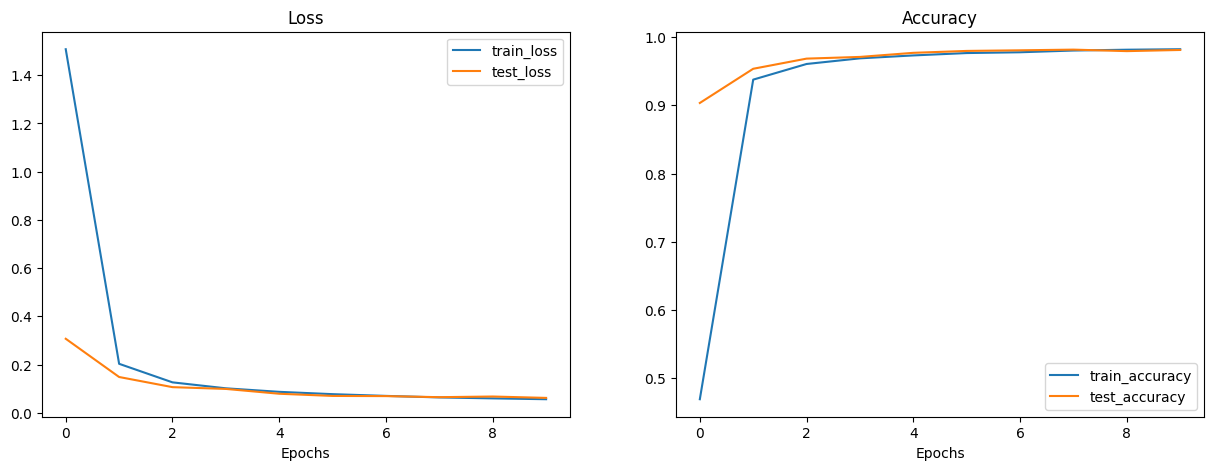

In [156]:
plot_loss_curves(results)

Shape of Sample Image:  (28, 28, 1)


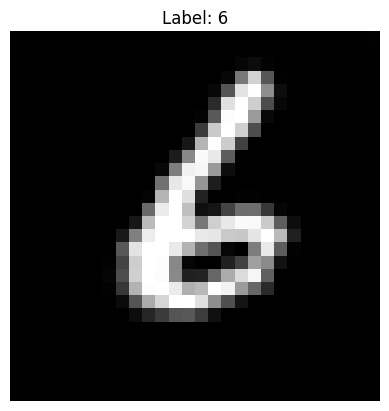

In [342]:
# sample = np.expand_dims(np.array(PIL.Image.open("sample.png").convert("L").resize((28, 28))), axis =0)
sample = PIL.Image.open("sample.png").convert("L").resize((28, 28))
sample = np.array(sample)
sample = sample.flatten()
sample = np.array([abs(x - 255) / 255 for x in sample], dtype=np.float32)
sample = np.reshape(sample, (28, 28, 1))
sample_label = 6
print("Shape of Sample Image: ", sample.shape)
plt.axis(False)
plt.title(f"Label: {sample_label}")
plt.imshow(sample)

In [343]:
sample_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
transformed_sample_image = sample_transform(sample)

In [345]:
with torch.inference_mode():
    sample_image_pred = model(transformed_sample_image.unsqueeze(dim=0).to(DEVICE))
sample_image_pred_prob = torch.softmax(sample_image_pred, dim=1)
sample_image_pred_label = torch.argmax(sample_image_pred_prob, dim=1)
print("Predicted Label: ", sample_image_pred_label)

Predicted Label:  tensor([6], device='cuda:0')
